In [1]:
from typing import *
import os
import argparse
import yaml
from PIL import Image
import numpy as np
import cv2 as cv
import torch
import torchvision
from facenet_pytorch import MTCNN
from tqdm import tqdm

from agnet.model import AGNet

from agnet.predict import Predictor

d:\Research Lab\computer vision\env\image\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = yaml.load(open("./agnet/predict_config.yaml",'r'))
FACE_MARGIN = config['model']['FACE_MARGIN']
FACE_PRESENT_THRESHOLD = config['model'].get("FACE_PRESENT_THRESHOLD",0.7)
device = torch.device("cpu")

mtcnn = MTCNN(image_size=config['data']['IMAGE_SIZE'], device=device)

GENDER_PREDICT_THRESHOLD = 0.5
gender_base_model = getattr(torchvision.models, config['model']['gender_base_model'])()
gender_dict = dict(
    _base_model=config['model']['gender_base_model'],
    output_dim=1,
    mlp_layer_name="",
    transfer_learning=False
)


In [3]:
def load_weights(model: torch.nn.Module, ck_path):
    params = torch.load(ck_path)
    print(model.load_state_dict(params['state_dict']))
    return model

In [4]:

gender_model = AGNet(gender_base_model,  **gender_dict)
gender_model = load_weights(gender_model, config['model']['gender_model_path'])

predictor = Predictor(
    mtcnn, 
    gender_model=gender_model, 
    device=device,
    image_size=config['data']['IMAGE_SIZE'],
    face_image_size=config['data']['FACE_IMAGE_SIZE'],
    FACE_PRESENT_THRESHOLD=FACE_PRESENT_THRESHOLD,
    GENDER_PREDICT_THRESHOLD=GENDER_PREDICT_THRESHOLD,
)

 resnet34
<All keys matched successfully>


In [5]:
image_path = "D:/WORK/freelance/agnet/dataset/utkface/part3/25_1_3_20170119172052720.jpg"

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=962x601 at 0x1B0F2813F10>, 'total_face_present': 1, 'predict': [{'box': array([225.48912048339844, 151.96766662597656, 388.1777648925781,
       306.6986389160156], dtype=object), 'face_logits': 0.9995788931846619, 'gender': 'male', 'gender_score': 0.9340671077370644}], 'file_path': 'D:/WORK/freelance/agnet/dataset/utkface/part1/25_1_0_20170104022204452.jpg'}


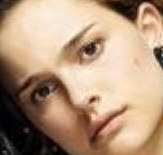

In [33]:
# image_path = file_path
res = predictor.predict_byfile(image_path,margin=40)
print(res)
res['image'].crop(res['predict'][0]['box'])

In [21]:
import pandas as pd

In [22]:
df = pd.read_csv("test/eval/eval_utkface.csv")

In [23]:
f_df = df[df['p_gender'].map(lambda x: "|" not in str(x))]

In [24]:
f_df.dropna(inplace=True)

In [25]:
from sklearn.metrics import classification_report

In [26]:
f_df = f_df[f_df['gender'].map(lambda x:x in [0,1])]

In [27]:
predicted = f_df['p_gender'].map(lambda x: int(x))

In [28]:
truth = f_df['gender'].map(lambda x: int(x))

(157, 4)
D:/WORK/freelance/agnet/dataset/utkface/part1/18_1_3_20170104221856991.jpg
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x481 at 0x1B0EF8C2C70>, 'total_face_present': 1, 'predict': [{'box': array([121.6727294921875, 82.41412353515625, 239.21249389648438,
       228.7627410888672], dtype=object), 'face_logits': 0.9999889135360718, 'gender': 'female', 'gender_score': 0.6320534944534302}], 'file_path': 'D:/WORK/freelance/agnet/dataset/utkface/part1/18_1_3_20170104221856991.jpg'}


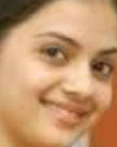

In [56]:
t = f_df[(predicted == truth)&(f_df['age']==18)]
print(t.shape)
image_path = t.sample(1).iloc[0]['file_paths']
print(image_path)

res = predictor.predict_byfile(image_path,margin=0)
print(res)
res['image'].crop(res['predict'][0]['box'])

<Axes: >

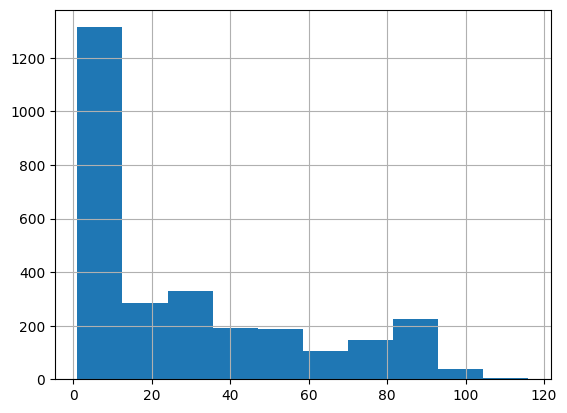

In [30]:
import matplotlib.pyplot as plt

f_df[predicted != truth]['age'].hist(bins=10)

In [31]:
print(classification_report(truth, predicted))

              precision    recall  f1-score   support

           0       0.75      0.87      0.80      6707
           1       0.84      0.70      0.76      6505

    accuracy                           0.79     13212
   macro avg       0.79      0.79      0.78     13212
weighted avg       0.79      0.79      0.78     13212

